In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.special import spherical_yn, spherical_jn

In [19]:
m1 = 939.565 #MeV/c^2
m2 = 3727.379 #MeV/c^2
hbar = 197 #MeV

mu = m1*m2/(m1+m2)

V0 = 50
a = 5 #fm

h = 0.001 #step size
p = 1 #initial condition for derivative



In [54]:
def V(r):
    # return -V0 if r <= a else 0
    return np.where(r <= a, -V0, 0)

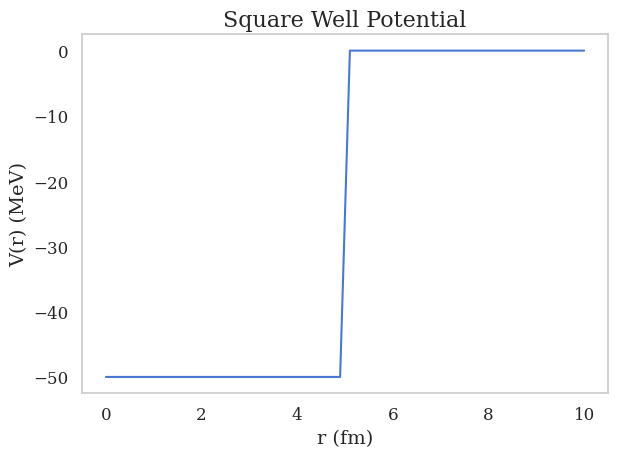

In [57]:
plt.plot(np.linspace(0, 10), V(np.linspace(0, 10)))

plt.xlabel("r (fm)")
plt.ylabel("V(r) (MeV)")
plt.title("Square Well Potential")

plt.grid(False)
plt.tight_layout()
plt.show()

In [21]:
def F(l, r, E):
    return (2*mu/(hbar**2)*(V(r)-E) + (l*(l+1)/(r**2)))

Matching via logarithmic derivative

In [22]:
# Numerov integration
def y_l(r, l, E):
    r_values = np.arange(0, a + 2*h, h) # need one step beyond well
    N = len(r_values)

    y = np.zeros(N)
    z = np.zeros(N+1)

    z[0] = 0.0
    z[1] = p * h

    for i in range(1, N):
        r_cur = r_values[i]
        F_val = F(l, r_cur, E)
        z[i+1] = (2*z[i] - z[i-1] + (h**2 * F_val * z[i]))
        y[i] = ((1-(h**2/12*F_val))*z[i]) / r_cur
    
    return y

In [23]:
def y_prime(y):
    r2_index = len(y)-1
    r1_index = r2_index-2
    return ((y[r2_index]-y[r1_index])/(2*h))

Plot Numerov v. exact solution

In [24]:
def numerov_phase_shift(k, l, E):

    ka = k * a

    y_array = y_l(a, l, E)
    y_val = y_array[len(y_array)-2] #at boundary
    y_prime_val = y_prime(y_array)
    
    numerator = y_prime_val*spherical_jn(l, ka) - k*y_val*spherical_jn(l, ka, True)
    denominator = k*y_val*(-1)*spherical_yn(l, ka, True) - y_prime_val*(-1)*spherical_yn(l, ka)

    delta_l = np.arctan2( numerator, denominator )

    return delta_l

In [25]:
E_values = np.linspace(0.1, 20.0, 100)
k_array = np.sqrt(2*mu*E_values / (hbar ** 2))

numerov_phase_shifts = []
l = 0

for k, E in zip(k_array, E_values):
    phase_shift = numerov_phase_shift(k, l, E)  
    numerov_phase_shifts.append(phase_shift)

numerov_phase_shifts = np.array(numerov_phase_shifts) * 180 / np.pi

In [26]:
def exact_phase_shift(k, K, l):

    ka = k * a
    Ka = K * a
    
    numerator = (K*spherical_jn(l,Ka,True)*spherical_jn(l,ka) - (k*spherical_jn(l,Ka)*spherical_jn(l,ka,True)))
    denominator = (k*spherical_jn(l,Ka)*(-1)*spherical_yn(l,ka,True) - (K*spherical_jn(l,Ka,True)*(-1)*spherical_yn(l,ka)))

    delta_l = np.arctan2( numerator , denominator )

    return delta_l
    

In [27]:
E_values = np.linspace(0.1, 20.0, 100)

k_array = np.sqrt(2*mu*E_values / (hbar ** 2))
kappa_array = np.sqrt((2*mu*(E_values+V0))/hbar**2)

l = 0
exact_phase_shifts = exact_phase_shift(k_array, kappa_array, l) * 180 / np.pi

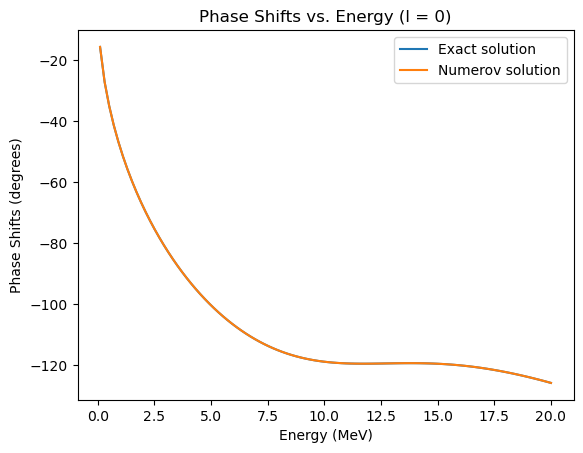

In [28]:
plt.plot(E_values, [i-180 for i in exact_phase_shifts], label = "Exact solution")
plt.plot(E_values, [i-180 for i in numerov_phase_shifts], label = "Numerov solution")
plt.xlabel("Energy (MeV)")
plt.ylabel("Phase Shifts (degrees)")
plt.title(f"Phase Shifts vs. Energy (l = {l})")
plt.legend()
plt.show()

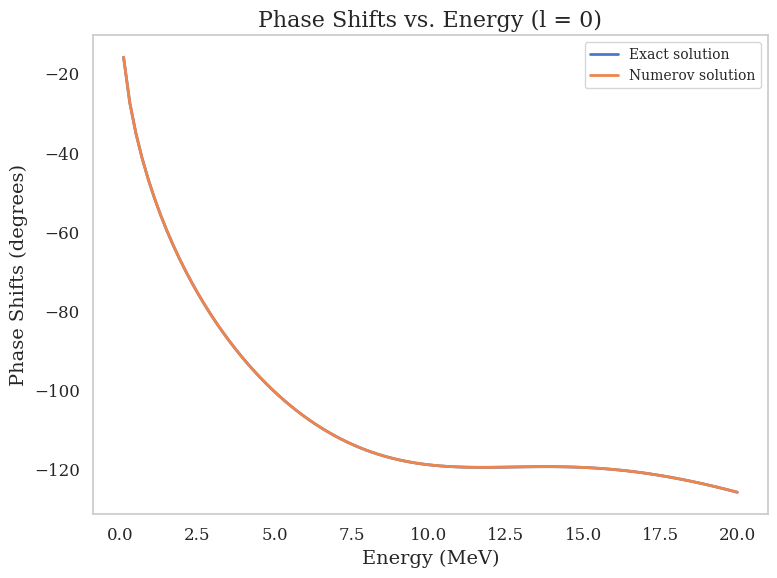

In [30]:

sns.set(style="whitegrid", palette="muted")

mpl.rcParams.update({
    'font.size': 14, 
    'font.family': 'serif',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

plt.figure(figsize=(8, 6))

# Plot the phase shifts for the exact solution and Numerov solution
plt.plot(E_values, [i - 180 for i in exact_phase_shifts], label="Exact solution", linewidth=2)
plt.plot(E_values, [i - 180 for i in numerov_phase_shifts], label="Numerov solution", linewidth=2)

# Customize plot labels and title
plt.xlabel("Energy (MeV)", fontsize=14)
plt.ylabel("Phase Shifts (degrees)", fontsize=14)
plt.title(f"Phase Shifts vs. Energy (l = {l})", fontsize=16)

plt.grid(False)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()


Check Numerov solution

In [31]:
def numerovf(x,ll,E,mu,potenital,hbar=197):
    return 2*mu/hbar**2*(potenital(x)-E)+ll*(ll+1.)/x**2

In [32]:
def Numerov_SC(ll,E,mu,potenital,npts_in_one_fm=128,hbar=197):
    a_idx = int(npts_in_one_fm*a)
    f_tilde = [0.]+[numerovf(i/npts_in_one_fm*1.,ll,E,mu,potenital)/(12.*npts_in_one_fm**2) for i in range(1,a_idx+2)]
    u = [0.,1./npts_in_one_fm]
    for i in range(2,a_idx+2):
        u.append((u[i-1]*(2.+10.*f_tilde[i-1])-u[i-2]*(1.-f_tilde[i-2]))/(1.-f_tilde[i]))
    y_val = [0.]+[ur/((i+1.)/npts_in_one_fm) for i,ur in enumerate(u[1:])]
    y_prime_val = (y_val[a_idx+1]-y_val[a_idx-1])*npts_in_one_fm/2.
    k = np.sqrt(2*mu*E/hbar**2)
    numerator = y_prime_val*spherical_jn(l, k*a) - k*y_val[a_idx]*spherical_jn(l, k*a, True)
    denominator = k*y_val[a_idx]*(-1)*spherical_yn(l, k*a, True) - y_prime_val*(-1)*spherical_yn(l, k*a)
    delta_l = np.arctan2( numerator, denominator )
    return delta_l

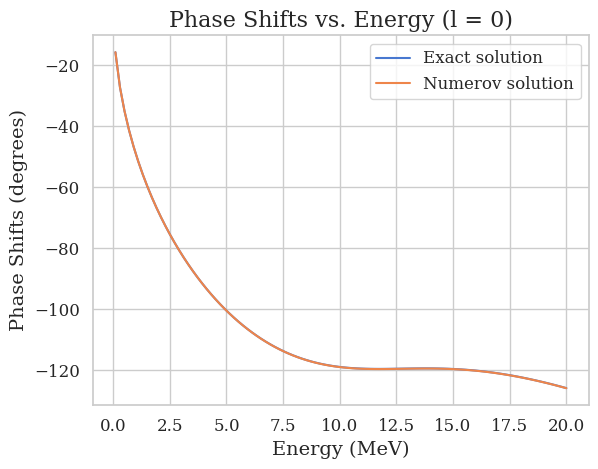

In [33]:
numerov_phase_shifts = []
l = 0

for k, E in zip(k_array, E_values):
    phase_shift = Numerov_SC(l, E, mu, V)  
    numerov_phase_shifts.append(phase_shift)

numerov_phase_shifts = np.array(numerov_phase_shifts) * 180 / np.pi

plt.plot(E_values, [i-180 for i in exact_phase_shifts], label = "Exact solution")
plt.plot(E_values, [i-180 for i in numerov_phase_shifts], label = "Numerov solution")
plt.xlabel("Energy (MeV)")
plt.ylabel("Phase Shifts (degrees)")
plt.title(f"Phase Shifts vs. Energy (l = {l})")
plt.legend()
plt.show()

Calculate and plot cross sections

In [38]:
def calculate_individual_cross_sections_numerov(E_values, l):
    cross_sections = []
    for E in E_values:
        k = np.sqrt((2*mu*E)/hbar**2)
        total_cross_section = 0.
        delta_l = numerov_phase_shift(k, l, E)
        total_cross_section += (2*l + 1) * (np.sin(delta_l)) ** 2
        cross_sections.append((4*np.pi / (k ** 2)) * total_cross_section)
    return cross_sections

In [43]:
def calculate_total_cross_sections_numerov(E_values, l_max):
    cross_sections = []
    for E in E_values:
        k = np.sqrt((2*mu*E)/hbar**2)
        total_cross_section = 0.
        for l in range(l_max + 1):
            delta_l = numerov_phase_shift(k, l, E)
            total_cross_section += (2*l + 1) * (np.sin(delta_l)) ** 2
        cross_sections.append((4*np.pi / (k ** 2)) * total_cross_section)
    return cross_sections

In [39]:
def calculate_individual_cross_sections_exact(E_values, l):
    cross_sections = []
    for E in E_values:
        k = np.sqrt((2*mu*E)/hbar**2)
        kappa = np.sqrt((2*mu*(E+V0))/hbar**2)
        total_cross_section = 0.
        delta_l = exact_phase_shift(k, kappa, l)
        total_cross_section += (2*l + 1) * (np.sin(delta_l)) ** 2
        cross_sections.append((4*np.pi / (k ** 2)) * total_cross_section)
    return cross_sections

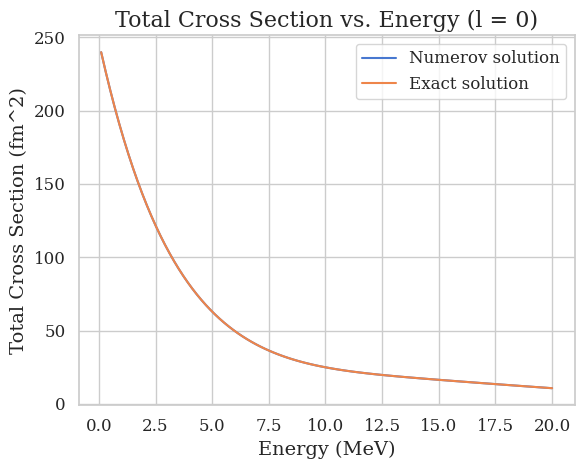

In [40]:
l_max = 0
numerov_cross_sections = calculate_individual_cross_sections_numerov(E_values, l_max)
exact_cross_sections = calculate_individual_cross_sections_exact(E_values, l_max)

plt.plot(E_values, numerov_cross_sections, label = "Numerov solution")
plt.plot(E_values, exact_cross_sections, label = "Exact solution")
plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm^2)")
plt.title(f"Total Cross Section vs. Energy (l = {l_max})")
plt.legend()
plt.show()

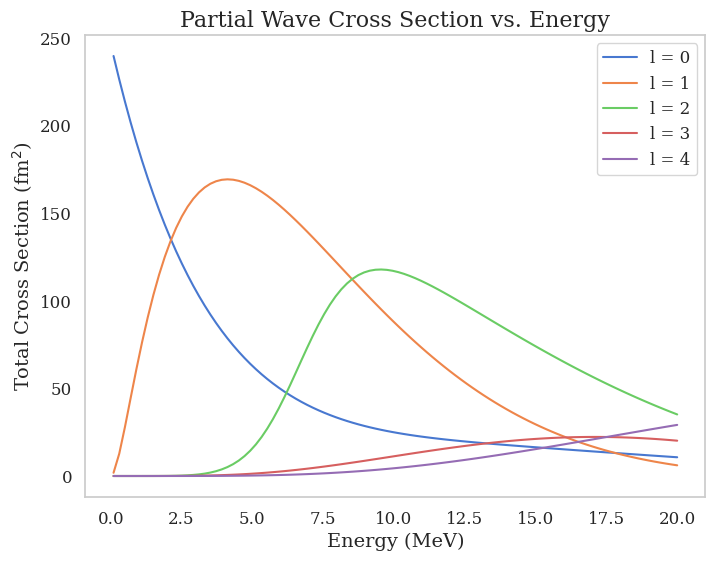

In [42]:
cross_sections_0 = calculate_individual_cross_sections_numerov(E_values, 0)
cross_sections_1 = calculate_individual_cross_sections_numerov(E_values, 1)
cross_sections_2 = calculate_individual_cross_sections_numerov(E_values, 2)
cross_sections_3 = calculate_individual_cross_sections_numerov(E_values, 3)
cross_sections_4 = calculate_individual_cross_sections_numerov(E_values, 4)

plt.figure(figsize=(8, 6))

plt.plot(E_values, cross_sections_0, label='l = 0')
plt.plot(E_values, cross_sections_1, label='l = 1')
plt.plot(E_values, cross_sections_2, label='l = 2')
plt.plot(E_values, cross_sections_3, label='l = 3')
plt.plot(E_values, cross_sections_4, label='l = 4')
plt.grid(False)
plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm$^2$)")
plt.title("Partial Wave Cross Section vs. Energy", fontsize=16)
plt.legend()
plt.show()

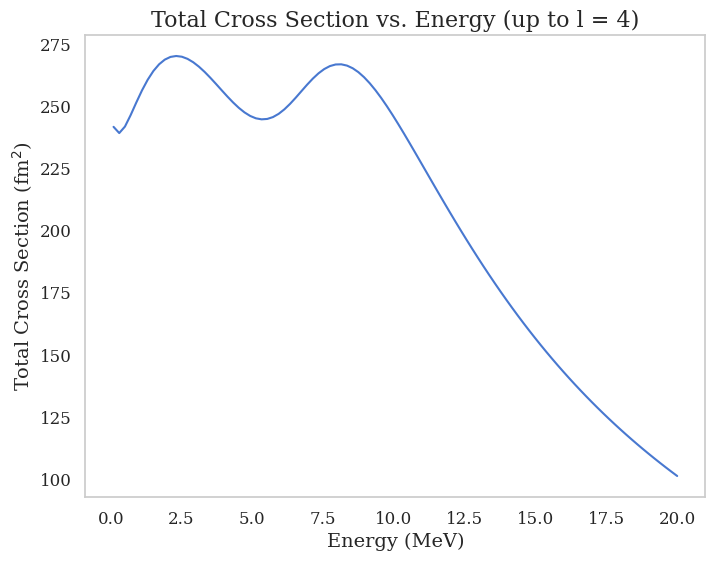

In [44]:
l_max = 4
cross_sections = calculate_total_cross_sections_numerov(E_values, l_max)

plt.figure(figsize=(8, 6))

plt.plot(E_values, cross_sections)
plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm$^2$)")
plt.title(f"Total Cross Section vs. Energy (up to l = {l_max})")
plt.grid(False)
plt.show()

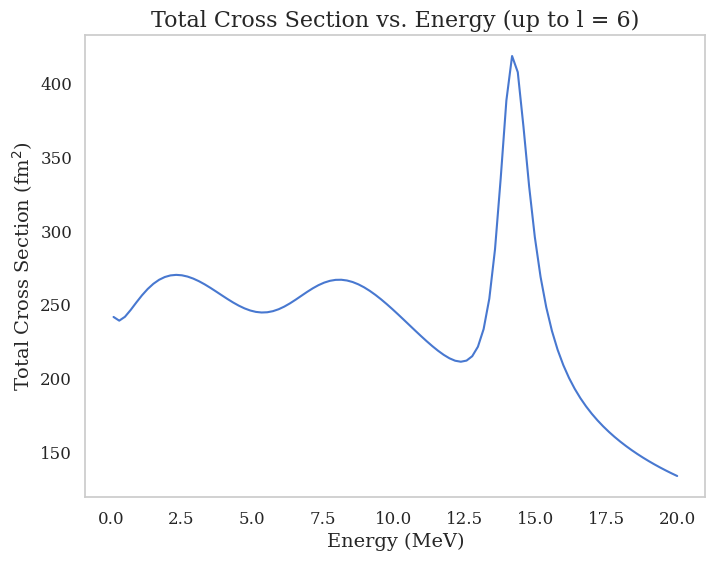

In [58]:
l_max = 6
cross_sections = calculate_total_cross_sections_numerov(E_values, l_max)

plt.figure(figsize=(8, 6))

plt.plot(E_values, cross_sections)
plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm$^2$)")
plt.title(f"Total Cross Section vs. Energy (up to l = {l_max})")
plt.grid(False)
plt.show()